### Import packages and Define utility functions

In [1]:
import numpy as np
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

### 1. Load the training dataset and perform an initial data inspection
Findings:
* Due to the format in the input file, datatype of some columns are not expected. They need to be fixed later.  

In [2]:
# Read CSV file into a pandas DataFrame
df = pd.read_csv('training_loan_data.csv', header=1, converters={'id': str, 
                                                                 'member_id': str})    
df.head()

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056,7550,36 months,16.24%,3 years,RENT,28000.0,NaN,debt_consolidation,...,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921,27050,36 months,10.99%,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,...,0.0,8.0,61.20%,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096,12000,36 months,10.99%,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,...,1.0,3.0,24%,18100.0,NaN,16416.617760,7137.0,1,157,0.0
3,10000004,12003142,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,...,1.0,3.0,54.60%,42200.0,NaN,38014.149760,799592.0,1,365,0.0
4,10000005,11993233,12000,36 months,13.53%,10+ years,RENT,40000.0,NaN,debt_consolidation,...,0.0,17.0,68.80%,7000.0,53.0,6471.462236,13605.0,1,157,0.0


### 2. Examine data quality

#### 2.1 A glance at date types
Findings:
* datatype of some columns need to be corrected so it relects the real data.

In [3]:
df.dtypes

id                              object
member_id                       object
loan_amnt                        int64
term                            object
int_rate                        object
emp_length                      object
home_ownership                  object
annual_inc                     float64
desc                            object
purpose                         object
percent_bc_gt_75               float64
bc_util                        float64
dti                            float64
inq_last_6mths                 float64
mths_since_recent_inq          float64
revol_util                      object
total_bc_limit                 float64
mths_since_last_major_derog    float64
tot_hi_cred_lim                float64
tot_cur_bal                    float64
application_approved_flag        int64
internal_score                   int64
bad_flag                       float64
dtype: object

In [4]:
# "term" should be numeric
df.term.value_counts()

term
36 months    144800
60 months     44657
Name: count, dtype: int64

In [5]:
# fix "term"
df['term_nb'] = np.where(df['term'].notnull() & ~df['term'].isna(), 
                         pd.to_numeric(df['term'].str[0:3], errors='coerce'), 
                         np.nan
                        )
df.term_nb.dtype, df.term_nb.value_counts()

(dtype('float64'),
 term_nb
 36.0    144800
 60.0     44657
 Name: count, dtype: int64)

In [6]:
# "int_rate", "revol_util" should be float. They are read in as characters due to the "%".
df['int_rate'].value_counts(), df['revol_util'].value_counts() 

(int_rate
 12.12%    9408
 13.11%    8258
 8.90%     7678
 14.33%    7208
 7.90%     6641
           ... 
 24.52%       6
 24.11%       5
 23.91%       3
 23.52%       2
 14.28%       1
 Name: count, Length: 145, dtype: int64,
 revol_util
 0%         629
 61.50%     344
 64.60%     343
 66.50%     340
 67.40%     337
           ... 
 102.70%      1
 103.40%      1
 107%         1
 104.90%      1
 113.90%      1
 Name: count, Length: 1068, dtype: int64)

In [7]:
# fix "int_rate", "revol_util"
df['int_rate_nb'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0
df['revol_util_nb'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
df['int_rate_nb'].dtype, df['int_rate_nb'][0: 5], df['revol_util_nb'].dtype, df['revol_util_nb'][0: 5]

(dtype('float64'),
 0    0.1624
 1    0.1099
 2    0.1099
 3    0.0762
 4    0.1353
 Name: int_rate_nb, dtype: float64,
 dtype('float64'),
 0    0.720
 1    0.612
 2    0.240
 3    0.546
 4    0.688
 Name: revol_util_nb, dtype: float64)

In [8]:
# "emp_length" could be numeric or character depending on the data. Let's take a look first.
df['emp_length'].value_counts()

emp_length
10+ years    61648
2 years      16257
5 years      14361
3 years      14058
< 1 year     13312
6 years      11981
1 year       11504
7 years      11287
4 years      10905
8 years       9040
9 years       7178
Name: count, dtype: int64

In [9]:
# no need to fix at this moment. In the modeling phase, values need to be encoded and/or binned then encoded.

#### 2.2 check duplicate rows, redundant / useless columns
Findings:
* 1334 duplicate rows are deleted.
* 3 columns ("term", "int_rate", "revol_util") are read in as incorrect format due to input format. They are fixed.
* column "application_approved_flag" is removed because it's not useful.

In [10]:
# duplicate rows
def rm_dup_rows(df_in):
    df = df_in.copy()
    dup_count = len(df) - len(df.drop_duplicates())
    print(f"There are no duplicate records. - {dup_count == 0}")
    
    if not len(df) == len(df.drop_duplicates()):
        df.drop_duplicates(inplace=True)
        print(f"{dup_count} of duplicate records were removed.")
    else:
        print("No duplicate rows detected.")
    print(f"The dataset has {len(df)} rows.")
    return df

df_dedup = rm_dup_rows(df)

There are no duplicate records. - False
1334 of duplicate records were removed.
The dataset has 197787 rows.


In [11]:
# duplicate IDs - "True" tells that values in columns "id" are all unique, which is as expected.
df_dedup.id.nunique() == len(df_dedup) 

True

In [12]:
# "application_approved_flag" could be useless because all records should be approved loans. to confirm:
df_dedup['application_approved_flag'].value_counts()

application_approved_flag
1    197787
Name: count, dtype: int64

In [13]:
# drop column "application_approved_flag", "term", "int_rate", "revol_util"
df_dedup.drop(['application_approved_flag', "term", "int_rate", "revol_util"], axis=1, inplace=True)

####  2.3 Overview of descriptive statistics of numerical variables
Findings:
*  There are 16 numerical variables, most of which has missing values.
    * First thing to be noted is that "bad_flag" has ~5% of records not having a value. Given it is the target variable of the project, records with missing value in the training dataset wouldn't add any value. They will be removed.
    * Among other variables with missing values, some have small amount of nulls (< 10%), while some have much bigger portion (84%). It may or may not imply a data quality issue. We will take a closer look in the following steps to determine the nature of the missing values and select proper approach to handle them respectively.
    * Looking at "bad_flag", there are only 7% of records are events (==1). Therefore, the potential issue of "unbalanced data" need to be noted/handled in the modeling phase.
    * Variables having outliers include "annual_inc", "bc_util", "inq_last_6mths", "total_bc_limit", "mths_sinc_last_major_derog", "tot_hi_cre_lim", "total_cur_bal".
    * Missing values and outliers will be investigated further in Section 3. 

In [14]:
df_dedup.describe()

,loan_amnt,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag,term_nb,int_rate_nb,revol_util_nb
count,197787.000000,1.881230e+05,179096.000000,179012.000000,188123.000000,188123.000000,160263.000000,180628.000000,32497.000000,180628.000000,1.603820e+05,197787.000000,188123.000000,188123.000000,188123.000000,187998.000000
mean,14070.907213,7.223871e+04,53.557030,66.829415,17.058663,0.803581,6.991770,20240.250448,41.792473,20239.458973,1.373305e+05,183.954451,0.069784,41.648177,0.142791,0.583865
std,8069.585694,5.182946e+04,34.148464,26.110808,7.596977,1.032841,5.880568,18885.232505,20.997645,18947.098163,1.507587e+05,104.890987,0.254784,10.181105,0.044369,0.230091
min,1000.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,14.000000,0.000000,36.000000,0.060000,0.000000
25%,8000.000000,4.500000e+04,25.000000,49.500000,11.340000,0.000000,2.000000,7800.000000,25.000000,7834.304802,2.747125e+04,105.000000,0.000000,36.000000,0.111400,0.425000
50%,12000.000000,6.200000e+04,50.000000,72.200000,16.780000,0.000000,6.000000,14700.000000,41.000000,14635.958700,8.076400e+04,157.000000,0.000000,36.000000,0.140900,0.605000
75%,19600.000000,8.700000e+04,80.000000,89.000000,22.580000,1.000000,11.000000,26500.000000,58.000000,26395.960438,2.081852e+05,256.000000,0.000000,36.000000,0.172700,0.766000
max,35000.000000,7.141778e+06,100.000000,339.600000,34.990000,8.000000,24.000000,522210.000000,165.000000,520643.298200,8.000078e+06,456.000000,1.000000,60.000000,0.260600,1.404000


In [15]:
(df_dedup.describe().loc['count'] - len(df_dedup)) / len(df_dedup)

loan_amnt                      0.000000
annual_inc                    -0.048861
percent_bc_gt_75              -0.094501
bc_util                       -0.094925
dti                           -0.048861
inq_last_6mths                -0.048861
mths_since_recent_inq         -0.189719
total_bc_limit                -0.086755
mths_since_last_major_derog   -0.835697
tot_hi_cred_lim               -0.086755
tot_cur_bal                   -0.189118
internal_score                 0.000000
bad_flag                      -0.048861
term_nb                       -0.048861
int_rate_nb                   -0.048861
revol_util_nb                 -0.049493
Name: count, dtype: float64

In [16]:
df_dedup_2 = df_dedup.loc[df_dedup['bad_flag'].notnull()].copy()
df_dedup_2.describe()

,loan_amnt,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag,term_nb,int_rate_nb,revol_util_nb
count,188123.000000,1.881230e+05,179096.000000,179012.000000,188123.000000,188123.000000,160263.000000,180628.000000,32497.000000,180628.000000,1.603820e+05,188123.000000,188123.000000,188123.000000,188123.000000,187998.000000
mean,14354.545962,7.223871e+04,53.557030,66.829415,17.058663,0.803581,6.991770,20240.250448,41.792473,20239.458973,1.373305e+05,187.641288,0.069784,41.648177,0.142791,0.583865
std,8115.066458,5.182946e+04,34.148464,26.110808,7.596977,1.032841,5.880568,18885.232505,20.997645,18947.098163,1.507587e+05,105.482445,0.254784,10.181105,0.044369,0.230091
min,1000.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,14.000000,0.000000,36.000000,0.060000,0.000000
25%,8000.000000,4.500000e+04,25.000000,49.500000,11.340000,0.000000,2.000000,7800.000000,25.000000,7834.304802,2.747125e+04,105.000000,0.000000,36.000000,0.111400,0.425000
50%,12175.000000,6.200000e+04,50.000000,72.200000,16.780000,0.000000,6.000000,14700.000000,41.000000,14635.958700,8.076400e+04,159.000000,0.000000,36.000000,0.140900,0.605000
75%,20000.000000,8.700000e+04,80.000000,89.000000,22.580000,1.000000,11.000000,26500.000000,58.000000,26395.960438,2.081852e+05,261.000000,0.000000,36.000000,0.172700,0.766000
max,35000.000000,7.141778e+06,100.000000,339.600000,34.990000,8.000000,24.000000,522210.000000,165.000000,520643.298200,8.000078e+06,456.000000,1.000000,60.000000,0.260600,1.404000


In [17]:
# 'bad_flag'
df_dedup_2['bad_flag'].value_counts(), df_dedup_2['bad_flag'].sum() / len(df_dedup_2['bad_flag'])

(bad_flag
 0.0    174995
 1.0     13128
 Name: count, dtype: int64,
 np.float64(0.06978413059540832))

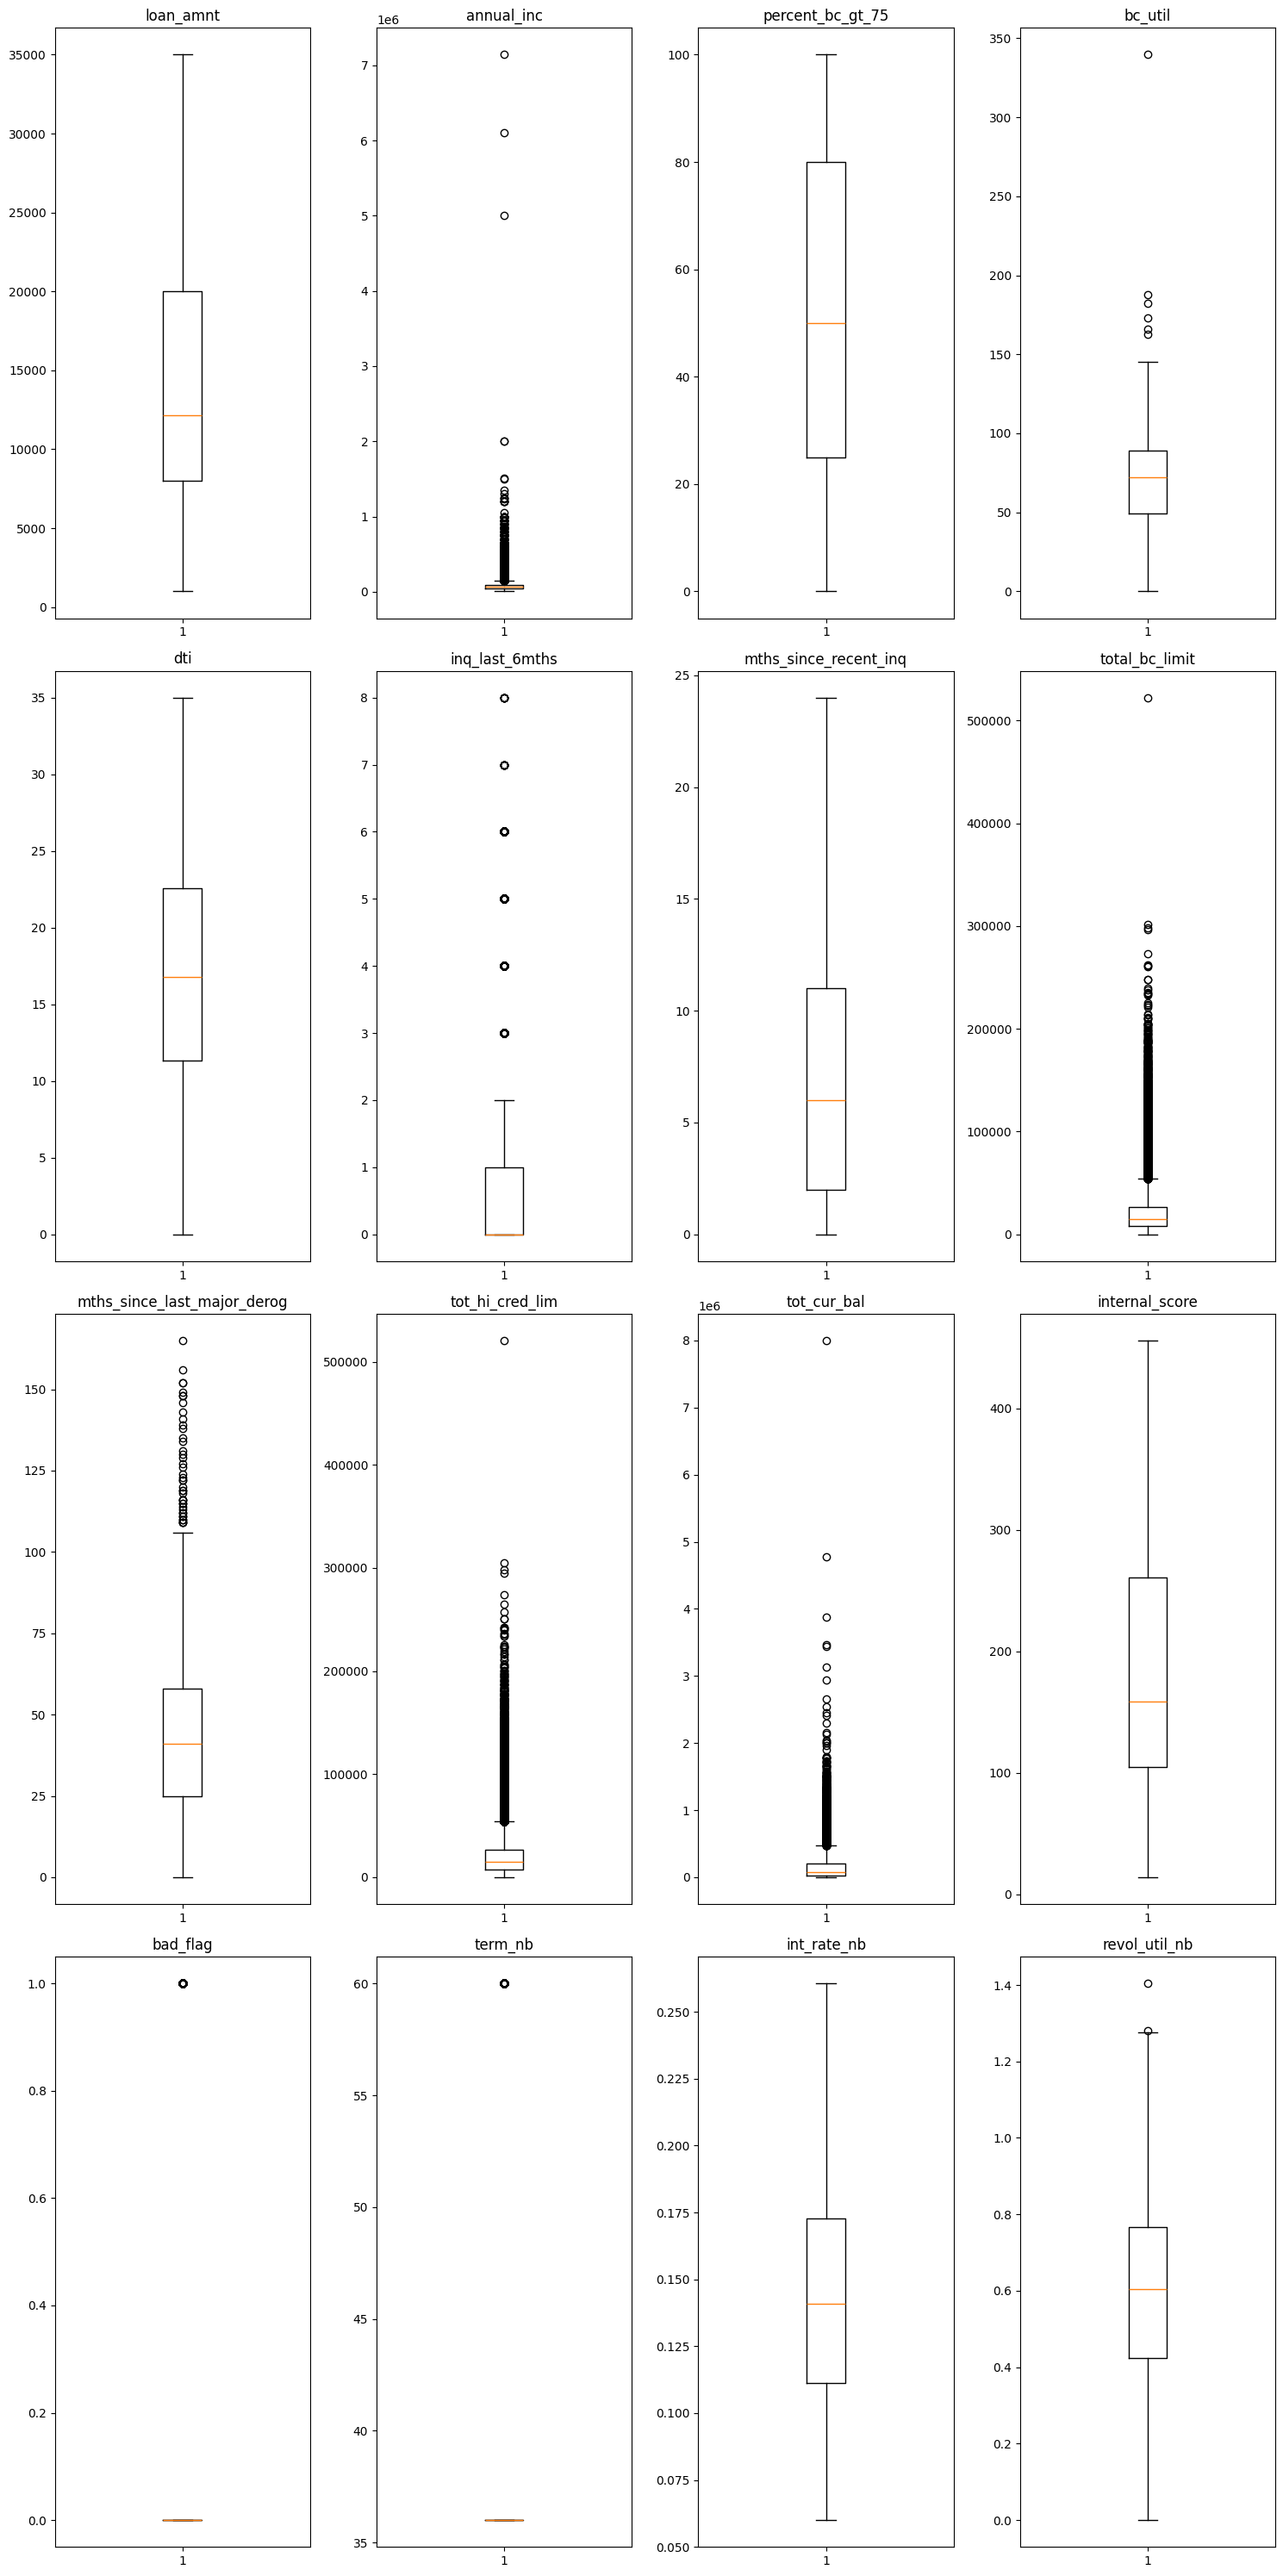

In [18]:
# Define a function that generates multiple box plot for all numeric variables in the input dataframe
def create_box_plot(data):
    """
    Create box plot for all numerical variables in the input dataframe.
    Since plt.boxplot function will not plot anything if there is null presenting, null values are droped before plotting.

    Parameters:
    data (DataFrame): The data containing the variables.

    Returns: None
    """
    data_to_plot = data.select_dtypes(include='number')
    variables = data_to_plot.columns

    rows = len(variables) // 4 if len(variables) % 4 == 0 else len(variables) // 4 + 1
    fig, axes = plt.subplots(rows, 4, figsize=(15, 30))
           
    for ax, var in zip(axes.flatten(), variables):
        ax.boxplot(data_to_plot[var].dropna())
        ax.set_title(var)

    plt.tight_layout()
    plt.show()


create_box_plot(df_dedup_2)

#### 2.4 Overview of non-numeric variables
Findings:
* There are 6 character variable.
    * 2 of them are identifiers which are not helpful for modeling, but may be useful as keys if we have multiple datasets.
    * "emp_length" and "home_ownership", "purpose" are categorical. They will be encoded with or without bins in the modeling phase.
    * "desc" may provide additional info when we look at any particular record. Missing values in "desc" should not be a concern.
    * "emp_length" has 7,877 missing values.
    * "home_ownership" has 42 values being "NONE". Based on the metadata, these should be missing. It is convinced that "NONE" was read as a string while importing the csv file.
    * Missing values and outliers will be investigated further in Section 3. 

In [19]:
character_columns = df_dedup_2.select_dtypes(include='object').columns
df_dedup_2[character_columns].head()

,id,member_id,emp_length,home_ownership,desc,purpose
0,10000001,11983056,3 years,RENT,NaN,debt_consolidation
1,10000002,12002921,10+ years,OWN,Borrower added on 12/31/13 > Combining high ...,debt_consolidation
2,10000003,11983096,4 years,RENT,Borrower added on 12/31/13 > I would like to...,debt_consolidation
3,10000004,12003142,5 years,MORTGAGE,NaN,debt_consolidation
4,10000005,11993233,10+ years,RENT,NaN,debt_consolidation


In [20]:
for c in character_columns:
    print(f"# of Missing values in {c}: {df_dedup_2[c].isnull().sum() / 1}")

# of Missing values in id: 0.0
# of Missing values in member_id: 0.0
# of Missing values in emp_length: 7877.0
# of Missing values in home_ownership: 0.0
# of Missing values in desc: 106662.0
# of Missing values in purpose: 0.0


In [21]:
for c in ['emp_length', 'home_ownership', 'purpose']:
    print(f"{c}: {df_dedup_2[c].value_counts()}")

emp_length: emp_length
10+ years    61175
2 years      16143
5 years      14265
3 years      13965
< 1 year     13222
6 years      11916
1 year       11434
7 years      11207
4 years      10846
8 years       8950
9 years       7123
Name: count, dtype: int64
home_ownership: home_ownership
MORTGAGE    96979
RENT        75609
OWN         15447
OTHER          46
NONE           42
Name: count, dtype: int64
purpose: purpose
debt_consolidation    111436
credit_card            43143
home_improvement       10293
other                   8891
major_purchase          3655
small_business          2744
car                     1950
medical                 1518
wedding                 1330
house                   1093
moving                  1038
vacation                 910
renewable_energy         122
Name: count, dtype: int64


### Output cleaned dataset

In [22]:
df_dedup_2.to_csv('df_dedup_2.csv', index=False)